In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import scipy.signal as sp
import datetime as dt
from beam2ENU import beam2ENU
import seawater as sw
import oceans as oc
from scipy.interpolate import griddata
from ocean_tools import TKED


In [88]:
directory = '../../Data/deployment_raw/';
outdir = '../../plots/Ri/Ri_profile/';
deployment_name = 'deploy1_';
measurement_type = 'ctd_';
file_type = 'raw_'
grid = pd.DataFrame(columns=['N2','shr2','Ri']) # Note that there are now row data inserted.

In [89]:
def create_data(directory, c_file, a_file):
    #Open the CTD data file that has all data stored as pandas
    c_data = pd.read_pickle(directory+deployment_name+file_type+c_file)
    a_data = pd.read_pickle(directory+deployment_name+file_type+a_file)

    #Join CTD and ADCP data together (add time to CTD data)
    start_time = a_data["a_time"].values[1][:-10]
    start_time = dt.datetime.strptime(start_time,"%Y-%m-%dT%H:%M:%S")
    start_time = start_time - dt.timedelta(seconds=15)
    c_data["c_time"] = [start_time+dt.timedelta(seconds=x) for x in range(len(c_data["c_temp"].values))]
    c_data.index = pd.DatetimeIndex(c_data['c_time'])

    #And average ADCP to resample at 1Hz
    a_data.index = pd.DatetimeIndex(a_data['a_time'])
    a_data = a_data.resample('S').mean()
    #Combine both datasets into one dataset by time
    data = pd.concat([a_data, c_data], axis=1, sort=False).dropna(axis='rows')
    #data_start = data.index[data["c_pres"]>20][0]
    #data_end = data.index[data["c_pres"]>100][0]
    #data = data[data_start:data_end]
    return data

In [90]:
# def buoyancy_freq(data):
#     #Get buoyancy frequency
#     CT = gsw.CT_from_t(data['c_sal'],data['c_temp'],data['c_pres'])
#     SA = gsw.SA_from_SP(data['c_sal'],data['c_pres'],174,-43)
#     [N2,p_mid,dp] = gsw.Nsquared(SA,CT,data['c_pres'])
#     #[n2,q,p_ave] = sw.bfrq(data['c_sal'],data['c_temp'],data['c_pres'],-43)
#     #N2 = [item[0] for item in n2]
#     N2 = np.array(N2)
#     data['N2'] = np.append(N2,N2[-1])

#     #filter buoyancy frequency by removing outliers
#     data['N2'] = data["N2"].replace([np.inf, -np.inf], np.nan)
#     data['N2'] = data['N2'].mask(((data['N2']-data['N2'].mean()).abs() > data['N2'].std()))
#     data['N2'] = data['N2'].interpolate().rolling(10).mean().abs()
#     #data['N2'] = data['N2'].mask(((data['N2']-data['N2'].mean()).abs() > 3*data['N2'].std()))
#     #data['N2'] = data['N2'].interpolate()
#     #plt.plot(data['N2'])
#     #plt.show()
#     return data
def buoyancy_freq(data):
    #Get buoyancy frequency
    dp = np.diff(data['c_pres'].values,axis=0)
    data['dp'] = np.append(dp,dp[-1])
    data['dp'] = data['dp'].mask(((data['dp']-data['dp'].mean()).abs() > data['dp'].std()))
    data['dp'] = data['dp'].interpolate().rolling(5).mean()
    CT = gsw.CT_from_t(data['c_sal'],data['c_temp'],data['c_pres'])
    SA = gsw.SA_from_SP(data['c_sal'],data['c_pres'],174,-43)
    pdens = gsw.sigma0(SA, CT)
    data['pdens'] = pdens
    dpdens = np.diff(data['pdens'].values,axis=0)
    data['dpdens'] = np.append(dpdens,dpdens[-1])
    data['dpdens'] = data['dpdens'].mask(((data['dpdens']-data['dpdens'].mean()).abs() > data['dpdens'].std()))
    data['dpdens'] = data['dpdens'].interpolate().rolling(5).mean()    
    data['N2'] = (9.7963*data['dpdens'])/(data['pdens']*data['dp'])

    
    
    #filter buoyancy frequency by removing outliers
    #data['N2'] = data['N2'].mask(data['N2']< 0.000005)
    data['N2'] = data["N2"].replace([np.inf, -np.inf], np.nan)
    data['N2'] = data['N2'].mask(((data['N2']-data['N2'].mean()).abs() > data['N2'].std()))
    data['N2'] = data['N2'].interpolate().rolling(10).mean()
    #data['N2'] = data['N2'].mask(((data['N2']-data['N2'].mean()).abs() > 3*data['N2'].std()))
    #data['N2'] = data['N2'].interpolate()
    
    #Sorted
    data['pdens_sort'] = np.sort(pdens)
    dpdens_sort = np.diff(data['pdens_sort'].values,axis=0)
    data['dpdens_sort'] = np.append(dpdens_sort,dpdens_sort[-1])
    data['dpdens_sort'] = data['dpdens_sort'].mask(((data['dpdens_sort']-data['dpdens_sort'].mean()).abs() > data['dpdens_sort'].std()))
    data['dpdens_sort'] = data['dpdens_sort'].interpolate().rolling(5).mean()    
    data['N2_sort'] = (9.7963*data['dpdens_sort'])/(data['pdens_sort']*data['dp'])    
    
    return data

In [91]:
for profile in range(1):
    c_file = 'C'+("%07d" % (profile,))
    a_file = 'A'+("%07d" % (profile,))
    
    data = create_data(directory, c_file, a_file)
    data = buoyancy_freq(data)
    
#     #data binned by 1 meter
#     ttitle = "1 meter bins"
#     data['c_depth'] = data['c_depth'].round(0)
#     data = data.groupby(data['c_depth']).mean()
#     data['profile'] = [profile]*len(data)
    
    #data binned by other meter
    ttitle = "0.5 meter bins"
    #data['c_depth'] = data['c_depth']*0.5
    data['c_depth'] = data['c_depth'].round(0)
    data = data.groupby(data['c_depth']).mean()
    #data['c_depth'] = data['c_depth']/0.5
    data['profile'] = [profile]*len(data)
    
    #if profile not in [6,12,16,28,34,48,56]:
    #    grid = pd.concat([grid,data])
    if profile not in [48]:
        grid = pd.concat([grid,data])

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



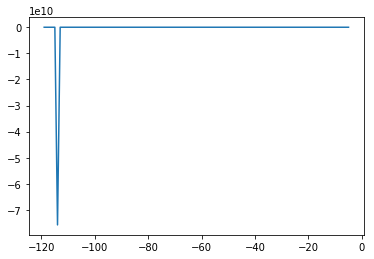

In [92]:
plt.plot(grid['N2_sort'])

In [93]:
[LT,Td,Nsqu,Lo,R,x_sorted,idxs] = TKED.thorpe_scales(data["c_depth"].values*-1,data['c_dens'].values,full_output=True)
data["Td"] = Td
data["Td"] = data["Td"].rolling(10).mean()
data["Td"] = data["Td"]**2
data["Td"] = data["Td"].rolling(10).mean()
data["LT"] = np.sqrt(data["Td"])

Text(0,0.5,'P (dbar)')

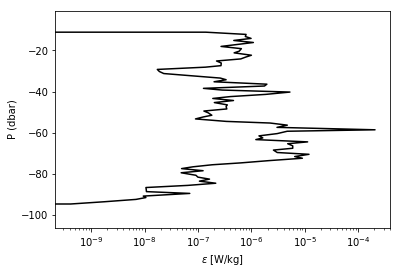

In [94]:
plt.semilogx((0.64*(data['LT']**2)*(data['N2_sort']**(3/2))),-data['c_pres'], 'k')
plt.xlabel("$\epsilon$ [W/kg]")
plt.ylabel("P (dbar)")